In [103]:
import pandas as pd
import numpy as np
import jsonlines
import json
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [179]:

use_sent_mask=False
if(use_sent_mask):
    maskfolder='sent_classifier_wikievent_512_60_1bs_2DAYS'
    mask=open('results/'+maskfolder+'/generated_predictions.txt').readlines()

    
using_binary_clf_top = False

predfolder = 'multitask4mixbidspec2verbose2_prin_ml_1024_50_4bs_2DAYS'
goldfolder = 'multitask4mix_bi'


#lab='src21'
lab=''
relcol='src_label'

golddf = pd.read_csv(goldfolder+'/testml.csv')
#golddf = pd.read_csv(goldfolder+'/test.csv')
#clfs = pd.read_csv(goldfolder+'/testcasieevclf.csv')


ds = ''
gold = golddf[relcol]
#txt = golddf['text']
#gold=gtype

if('FIXED' not in predfolder):
    
    #if('tkinstr' in predfolder or 't5L' in predfolder):
    #    pred = open('results/'+predfolder+'/test_generations.txt').readlines()
    #    pred = [p[0:-1] for p in pred] # removing \n suffix
        
    #else:
    pred = open('results/'+predfolder+'/generated_predictions.txt').readlines()
    pred[-1] = pred[-1]+'\n'
    pred = [p[2:-2] for p in pred] # removing b' prefix and \n suffix

if(using_binary_clf_top):
    pred = open('results/'+predfolder+'/generated_predictions_new.txt').readlines()
    print('fixed')
pred = pd.Series(pred)
labelsep = ' | ' # separates multiple entity+type combos

termsep = '->' # separates entity and type

In [180]:
print(len(gold),len(pred))

2625 2625


In [181]:
#pred[:-1]

In [182]:
#pred.iloc[-1]+'e'

In [183]:
'''rem = pred.iloc[-1]+'e'
pred = list(pred[:-1])
pred.append('contact.threatencoerce')
pred.append(rem+'e')
#+['contact.threatencoerce']+[rem+'e']'''

"rem = pred.iloc[-1]+'e'\npred = list(pred[:-1])\npred.append('contact.threatencoerce')\npred.append(rem+'e')\n#+['contact.threatencoerce']+[rem+'e']"

In [184]:
gold

0       planned_process | gene_expression | positive_r...
1       metastases | results | inhibition | mediated |...
2       inhibition->negative_regulation | transfer->pl...
3       planned_process | blood_vessel_development | n...
4                     Inhibition | therapy | angiogenesis
                              ...                        
2620                                   neovascularization
2621         neovascularization->blood_vessel_development
2622                                      planned_process
2623                                       prefabrication
2624                      prefabrication->planned_process
Name: src_label, Length: 2625, dtype: object

In [185]:
if(len(pred)>len(gold)):
    pred = [p for p in pred if len(p)>0]

In [186]:
len(gold),len(pred)

(2625, 2625)

In [187]:
pred[1],pred[2],pred[3]

('The event triggers in this text are mediated, inhibition, growth, metastases, transfer, expression',
 'The event triggers and their types in this text are: growth is a trigger of type growth, inhibition is a trigger of type negative_regulation, expression is a trigger of type gene_expression, transfer is a trigger of type planned_process, results is a trigger of type positive_regulation, mediated is a trigger of type positive_regulation, metastases is a trigger of type localization',
 'The types of events in this text are negative_regulation, blood_vessel_development, planned_process')

In [188]:

if(use_sent_mask):
    
    pred_o = pred.copy()
    pred=[]
    for i,r in enumerate(pred_o):
        if(mask[i][2:-2]=='False'):
            #print('Found')
            pred.append('NONE')
        else:
            pred.append(r)
    ### the ones which are 0, conver preds to NONE

print(len([p for p in pred if p=='NONE']))
print(len(pred))

0
2625


In [189]:
predz=[]
sb = golddf['subtask']

if('src21' in predfolder or lab=='src21'):
    ## reversed outputs/ convert to src_label1 format
    
    for p in pred:
        fin=[]
        events = [x.strip() for x in p.split('|')]
        for e in events:
            #print(e)
            if('->' not in e):
                typ,trigs=['','']
            else:
                typ,trigs=e.split('->')[0:2]
            
            for tg in trigs.split('@'):
                fin.append(tg+'->'+typ)
        if(p.strip()=='->'):
            predz.append('NONE')
        else:
            predz.append(' | '.join(fin))
        
    pred = predz.copy()

    
if('src12' in predfolder or lab=='src12'):
    
    for idx,p in enumerate(pred):
        nm=[]
        if('NONE' in p):
            predz.append('NONE')
            continue
        
        if('EV-EX' not in sb[idx]):
            predz.append(p)
            continue
        events = [x.strip() for x in p.split('|')]
        #print(events,sb.iloc[idx])
        for e in events:
            if('->' not in e):
                continue
            tg = e.split('->')[0]
            tps = e.split('->')[1].split('@')
            nm += [tg+'->'+p for p in tps]
        if(len(nm)==0):
            nm = ['NONE']
        predz.append(' | '.join(nm))
        
    pred = predz.copy()

In [190]:
print(gold[0]+'\n\n'+pred[0])
print('**************************')
print(gold[1]+'\n\n'+pred[1])
print('**************************')
print(gold[2]+'\n\n'+pred[2])

planned_process | gene_expression | positive_regulation | localization | negative_regulation | growth

The types of events in this text are negative_regulation, localization, gene_expression, growth, positive_regulation, planned_process
**************************
metastases | results | inhibition | mediated | transfer | expression | growth

The event triggers in this text are mediated, inhibition, growth, metastases, transfer, expression
**************************
inhibition->negative_regulation | transfer->planned_process | mediated->positive_regulation | expression->gene_expression | metastases->localization | growth->growth | results->positive_regulation

The event triggers and their types in this text are: growth is a trigger of type growth, inhibition is a trigger of type negative_regulation, expression is a trigger of type gene_expression, transfer is a trigger of type planned_process, results is a trigger of type positive_regulation, mediated is a trigger of type positive_regula

In [191]:

if('verb' in predfolder):
    p1 = pred.str.replace('The types of events in this text are ','').str.replace('The event triggers in this text are ','').str.replace('Events in this text: ','').str.replace('The event triggers and their types in this text are: ','')
    p2 = p1.str.replace(' is a trigger of type ','->').str.replace(',',' |')
    pred = p2

In [192]:
print(gold[0]+'\n\n'+pred[0])
print('**************************')
print(gold[1]+'\n\n'+pred[1])
print('**************************')
print(gold[2]+'\n\n'+pred[2])

planned_process | gene_expression | positive_regulation | localization | negative_regulation | growth

negative_regulation | localization | gene_expression | growth | positive_regulation | planned_process
**************************
metastases | results | inhibition | mediated | transfer | expression | growth

mediated | inhibition | growth | metastases | transfer | expression
**************************
inhibition->negative_regulation | transfer->planned_process | mediated->positive_regulation | expression->gene_expression | metastases->localization | growth->growth | results->positive_regulation

growth->growth | inhibition->negative_regulation | expression->gene_expression | transfer->planned_process | results->positive_regulation | mediated->positive_regulation | metastases->localization


In [193]:
def div(a,b):
    if b==0:
        return 0;
    else:
        return a/b

In [194]:
'''def macro(gold,pred,task,dataset):
    classes=[]
    f1s=[]
    for i,r in clfs.iterrows():
        c = [p.strip() for p in r[relcol].split('|')]
        classes+=c
        
    print(pd.Series(classes).nunique(), ' unique classes')
    cdt = {key: [] for key in classes}
    
    for cf in classes:
        print('cf ',cf)
        indxs = clfs[clfs[relcol].str.contains(cf)].index
                
    
    print('avged f1 across classes: ',np.sum(f1s)/len(f1s))
    ### get clf list from ev-clf dataset.split on '|' and strip
    ### get values by adding lists and getting unique
    ### for each class, get indices (will be same for evex and evclf? added in same order right).
    ##### dict. classname:[indices]
    ### for those sentences run scoring()
    ### average over all classes.'''

"def macro(gold,pred,task,dataset):\n    classes=[]\n    f1s=[]\n    for i,r in clfs.iterrows():\n        c = [p.strip() for p in r[relcol].split('|')]\n        classes+=c\n        \n    print(pd.Series(classes).nunique(), ' unique classes')\n    cdt = {key: [] for key in classes}\n    \n    for cf in classes:\n        print('cf ',cf)\n        indxs = clfs[clfs[relcol].str.contains(cf)].index\n                \n    \n    print('avged f1 across classes: ',np.sum(f1s)/len(f1s))\n    ### get clf list from ev-clf dataset.split on '|' and strip\n    ### get values by adding lists and getting unique\n    ### for each class, get indices (will be same for evex and evclf? added in same order right).\n    ##### dict. classname:[indices]\n    ### for those sentences run scoring()\n    ### average over all classes."

In [195]:
def scoring(gold,pred,task,indices=None,verbose=True,skipneg=True):
    tp = 0
    predn=0
    goldn=0
    skipped=0
    
    x=0
    cor=[]
    posind=[]

    for ind,row in enumerate(pred):
        #row = row.replace(': ','->')
        
        if(row=='->'):
            row='NONE'
        if(indices is not None):
            gold2 = gold[indices[x]]
        x+=1
        
        if(str(gold2)=='nan'):
            gold2=''
        
        '''
        if(gold2=='NONE'):
            continue
        '''
        
        posind.append(ind)    
        row = row.split('|')
        gold2 = gold2.split('|')
        
        
        gold2 = [g.strip() for g in gold2]
        row = [g.strip() for g in row]
        
        r2 = row.copy()
        g2 = gold2.copy()
        
        #print(gold2,'\n\n',row)
        #break
        r2 = [r for r in row if len(r)>1]
        
        
        #gold[i] = str(gold[i]).split(' |')
        
        if(task=='EV-CLF'):
            row = list(set(row))
            gold2 = list(set(gold2))
            
        row.sort()
        gold2.sort()
        cor.append(row==gold2)
        
        if(skipneg and gold2[0]=='NONE'):
            skipped+=1
            continue

        
        for elem in row:
            if(len(elem)<1):
                continue
            
                
            
            if(elem in gold2): # exact phrase present
                tp+=1

            
                
                # NEW
                gold2.remove(elem)
            
        gold2 = g2.copy()
        for g in gold2: # part of pred phrase present in gold
            if(len(g)<1):
                continue
            
        
        predn+=len(row)-len([p for p in row if len(p)<1])
        goldn+=len(gold2)-len([p for p in gold2 if len(p)<1])
        #print('tp: ',tp,' predn: ',predn,' goldn: ',goldn)
        #print('tp_rel: ',tp_relaxed)
        #print('tp_rel2: ',tp_relaxed2)

    p = div(tp,predn)
    r = div(tp,goldn)
    f1 = div(2*p*r,(p+r))

    if(verbose):
        print('skipped: ',skipped)
        print('\nPrecision: ',p,'\nRecall: ',r,'\nF1-score: ',f1)

    
    '''
    prel = div(tp_relaxed,predn)
    rrel = div(tp_relaxed,goldn)
    f1rel = div(2*prel*rrel,(prel+rrel))
    
    print('\nRELAXED SCORING 1\nPrecision: ',prel,'\nRecall: ',rrel,'\nF1-score: ',f1rel)

    prel2 = div(tp_relaxed2,predn)
    rrel2 = div(tp_relaxed2,goldn)
    f1rel2 = div(2*prel2*rrel2,(prel2+rrel2))

    print('\nRELAXED SCORING 2\nPrecision: ',prel2,'\nRecall: ',rrel2,'\nF1-score: ',f1rel2)
    '''
    return posind,cor,p,r,f1

In [196]:
if('dataset' not in golddf.columns):
    golddf['dataset'] = ds

for dataset in golddf['dataset'].unique():
    
    pdfs=[]
    print('------------------------------------------')
    print('dataset: ',dataset)
    
    df1 = golddf[golddf['dataset']==dataset]
    if('subtask' not in df1.columns):
        df1['subtask'] = ['EV-EX']*len(df1)
    for task in df1['subtask'].unique():
        print('------------------------------------------')
        print('subtask: ',task)
        
        # get list of indices and mask on pred
        
        #print(df2.index)
        #print(len(df2),len(pred[df2.index]))
        df2 = df1[df1['subtask']==task] # GOLD
        g = df2[relcol]
        ds = df2['dataset']
        txt = df2['text']
        
        p = pd.Series(pred)[df2.index]
        
        print(len(g),len(p))
    
        #print(g,p)
        posind,cor,_,_,_ = scoring(g,p,indices=df2.index,task=task,skipneg=True)
        
        posind1,cor1,_,_,_ = scoring(g,p,indices=df2.index,task=task,skipneg=False)
        
        ofile = 'results/'+predfolder+'/'+task+'_'+dataset+'.csv'
        print(len(p),len(g),len(cor),len(ds),len(txt))
        
        
        pdf = pd.DataFrame(data={'pred':p,'gold':g,'correct':cor,'dataset':ds,'text':txt})
        
        if(use_sent_mask):
            pdf['pred_unmask'] = pd.Series(pred_o)[df2.index]
        pdfs.append(pdf)
        
           
    
        
        
        '''
        if(task=='EV-CLF'):
            ct=0
            for i,r in pdf.iterrows():
                ct+='.'.join(r['pred'].split('.')[0:-1]) == '.'.join(r['gold'][0].split('.')[0:-1])
                #print('.'.join(r['pred'].split('.')[0:-1]))
                #print('.'.join(r['gold'][0].split('.')[0:-1]))
            print(ct/len(pdf))
        '''
        #pdf = pd.concat(pdfs)
        pdf.to_csv(ofile,index=False)


------------------------------------------
dataset:  mlee_processed_sent
------------------------------------------
subtask:  EV-CLF
875 875
skipped:  172

Precision:  0.8223684210526315 
Recall:  0.8121677495569994 
F1-score:  0.8172362555720654
skipped:  0

Precision:  0.8096008629989212 
Recall:  0.8048257372654155 
F1-score:  0.8072062382360848
875 875 875 875 875
------------------------------------------
subtask:  EV-ID
875 875
skipped:  172

Precision:  0.7912957467853611 
Recall:  0.7916872835230084 
F1-score:  0.7914914667326243
skipped:  0

Precision:  0.78125 
Recall:  0.786593707250342 
F1-score:  0.7839127471029311
875 875 875 875 875
------------------------------------------
subtask:  EV-EX
875 875
skipped:  172

Precision:  0.7417315175097277 
Recall:  0.7545769421078674 
F1-score:  0.7480990924699534
skipped:  0

Precision:  0.7347302719572002 
Recall:  0.7514819881440948 
F1-score:  0.7430117222723174
875 875 875 875 875


In [197]:
predfolder

'multitask4mixbidspec2verbose2_prin_ml_1024_50_4bs_2DAYS'

In [198]:
len(txt),txt.nunique()

(875, 875)

In [199]:
len([p for p in g if 'NONE' not in p])

703

In [200]:
train_res = pd.read_json('results/'+predfolder+'/train_results.json',typ='series')
state = pd.read_json('results/'+predfolder+'/trainer_state.json')

In [201]:
epwiseloss = pd.DataFrame(list(state['log_history']))
epwiseloss.head()

,epoch,learning_rate,loss,step,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,1.52,0.000048,0.4011,500,NaN,NaN,NaN,NaN,NaN
1,3.04,0.000047,0.2306,1000,NaN,NaN,NaN,NaN,NaN
2,4.56,0.000045,0.1791,1500,NaN,NaN,NaN,NaN,NaN
3,6.08,0.000044,0.1527,2000,NaN,NaN,NaN,NaN,NaN
4,7.60,0.000042,0.1273,2500,NaN,NaN,NaN,NaN,NaN


multitask4mixbidspec2verbose2_prin_ml_1024_50_4bs_2DAYS
{'epoch': 50.0, 'step': 16450, 'total_flos': 1.102800094182604e+17, 'train_loss': 0.067719119022682, 'train_runtime': 10003.1839, 'train_samples_per_second': 26.302, 'train_steps_per_second': 1.6440000000000001}


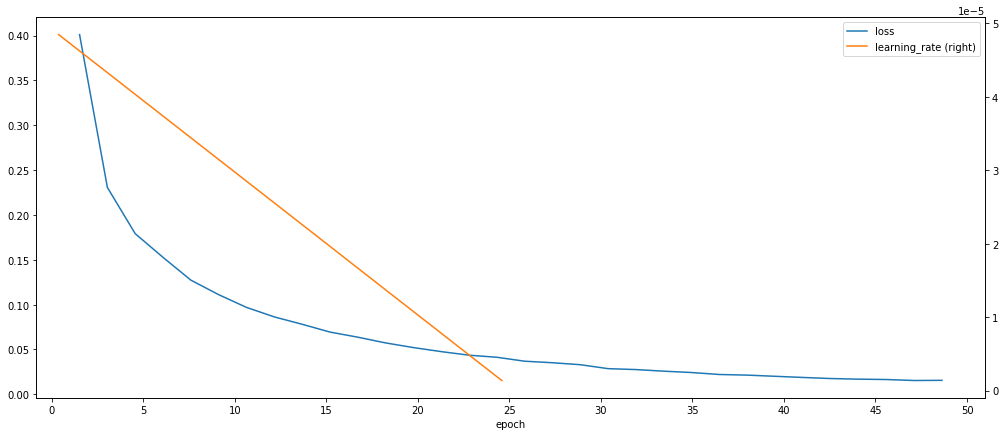

In [202]:
print(predfolder)
print(state['log_history'].iloc[-1])
epwiseloss.plot(x='epoch',y=['loss','learning_rate'],kind='line',secondary_y='learning_rate',figsize=(17,7))
plt.xticks(np.arange(0,101,5))
plt.show()

In [203]:
epwiseloss['loss'].iloc[-25:]

8     0.0781
9     0.0694
10    0.0637
11    0.0573
12    0.0521
13    0.0476
14    0.0436
15    0.0413
16    0.0369
17    0.0352
18    0.0330
19    0.0286
20    0.0276
21    0.0258
22    0.0243
23    0.0221
24    0.0214
25    0.0201
26    0.0188
27    0.0176
28    0.0169
29    0.0165
30    0.0154
31    0.0156
32       NaN
Name: loss, dtype: float64